## Using Muon for integrated analysis of BD Rhapsody multi-omic RNA-Seq & ATAC-Seq single-cell data

In this notebook, we will see how to learn a latent space jointly on two omics. 
This tutorial is adapted from [this](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/3-Multimodal-Omics-Data-Integration.html) original muon tutorial.

The data used in this example can be found in this demo data result: [AT206_Std_MO_ATAC.zip(2.0Gb)](https://bd-rhapsody-public.s3.amazonaws.com/Rhapsody-Demo-Data/AT206_Std_MO_ATAC.zip)

For a more detailed analysis of individual modalities, please see the specific tutorials for TCR/BCR RNA-Seq demo and ATAC-Seq.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Load packages used in this tutorial
import pandas as pd
import anndata as ad
import muon as mu
from muon import MuData
import scanpy as sc
# Import a module with ATAC-seq-related functions
from muon import atac as ac
import numpy as np

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.8 anndata==0.10.7 umap==0.5.3 numpy==1.24.2 scipy==1.10.1 pandas==2.2.2 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.10.4 pynndescent==0.5.10


In [3]:
# Data Import
# For AT206, there exists 2 madalities: rna and atac
mdata_raw = mu.read("AT206-Std-MO-ATAC.h5mu")
atac=mdata_raw['atac']
rna=mdata_raw['rna']

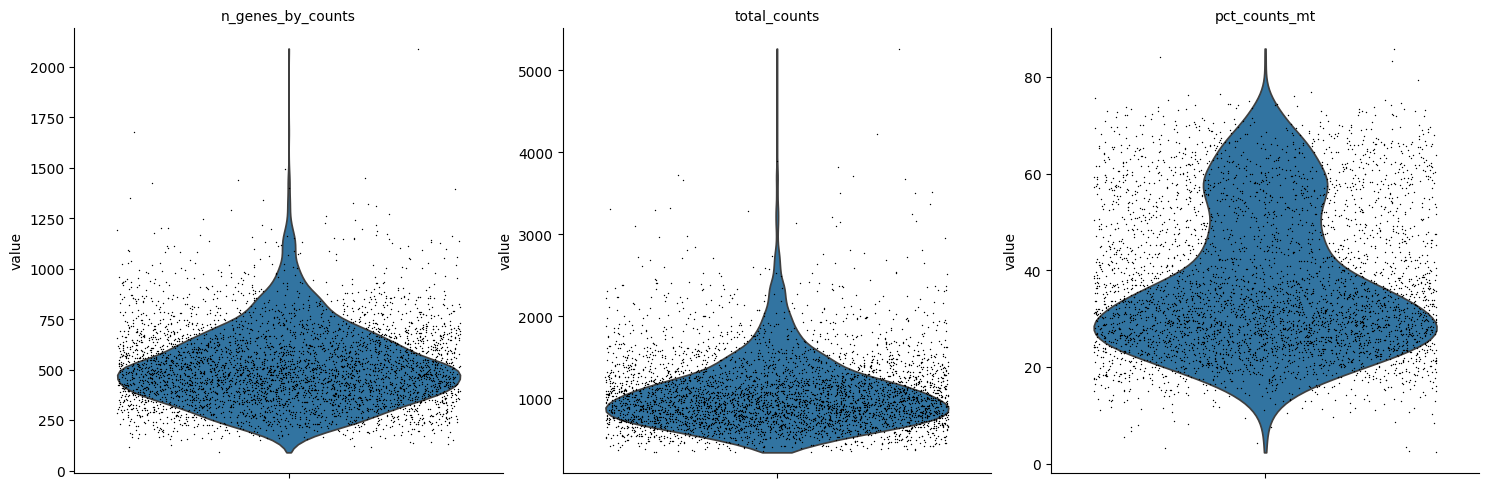

In [4]:
# mRNA QC metric visulization
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

### Filter Gene and Cells

In [5]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 10)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=3)
# but does in-place filtering and avoids copying the object

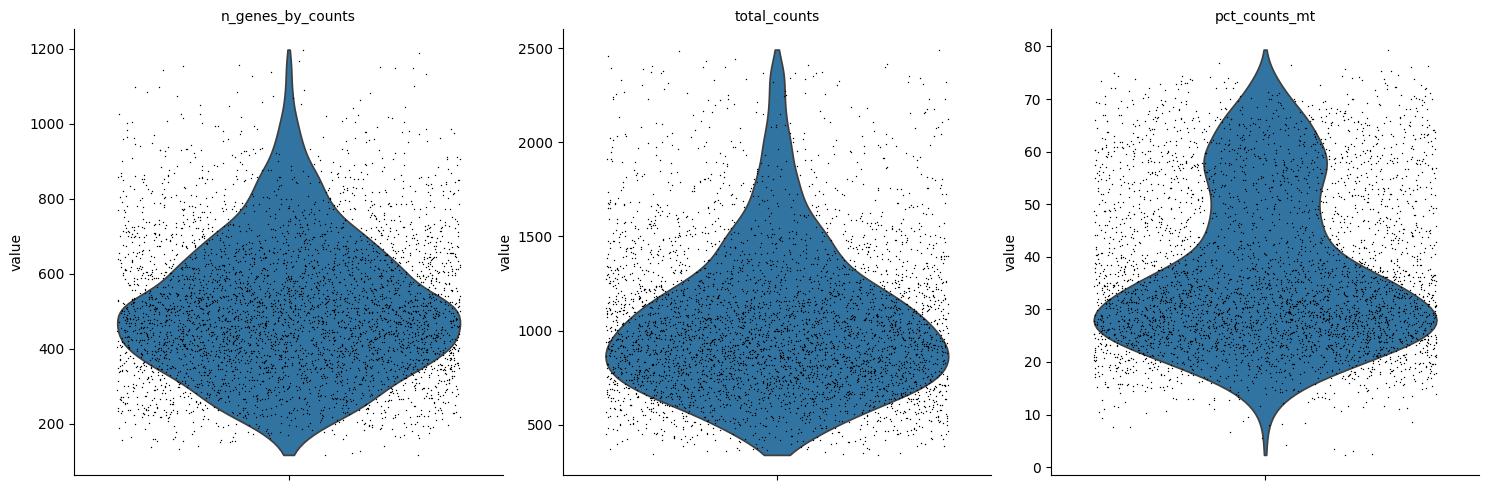

In [6]:
# filtering
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 10) & (x < 1200))
# This is analogous to
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 2500)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 80)
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [7]:
# basic mRNA analysis steps - see TCRBCR demo for detailed tutorial
sc.pp.normalize_total(rna,target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)
rna.raw = rna
sc.pp.scale(rna, max_value=10)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna, resolution=.5)
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')

## ATAC
See atac atac tutorial for analysis steps and visualization guide.

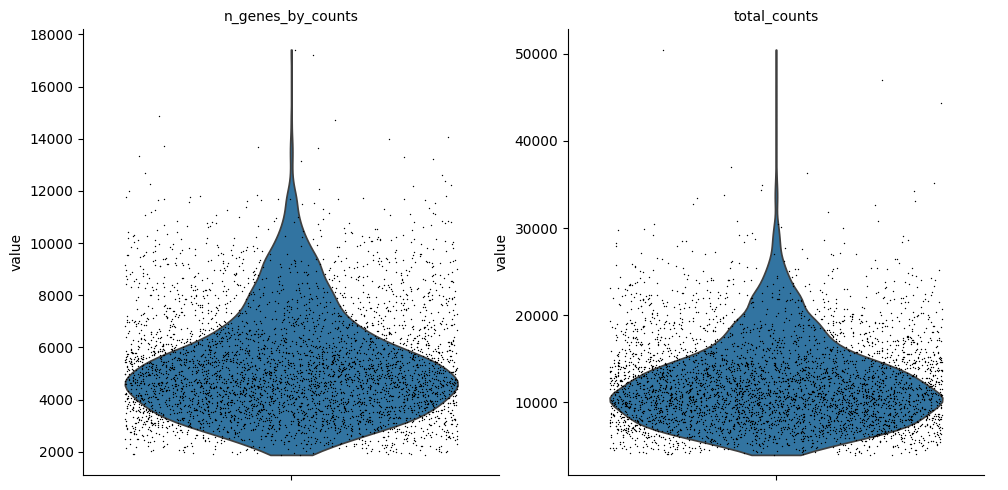

In [8]:
# basic metrics
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

### Filter Gene and Cells

In [9]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=3)
# but does in-place filtering and avoids copying the object

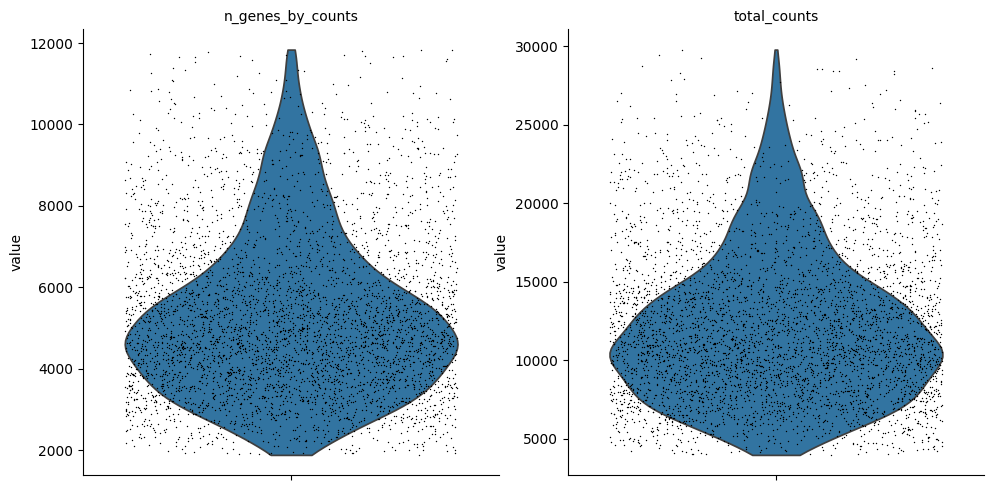

In [10]:
# filtering
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 10) & (x <= 12000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 10) & (x <= 30000))
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

Follow-up analysis steps for atac modality - all plotting steps has been ommited.

In [11]:
# basic ATAC analysis steps - refer to Atac only tutorial for detailed steps
atac.obs['NS']=1
# ac.tl.locate_fragments(atac, "AT206-Std-MO-ATAC_ATAC_Fragments.bed.gz")
# ac.pl.fragment_histogram(atac, region='chr1:1-2000000')
# ac.tl.nucleosome_signal(atac, n=1e6)
# mu.pl.histogram(atac, "nucleosome_signal")
# tss_feature = pd.read_csv('gencode.v42.primary_assembly.annotation-filtered_TSS.bed', sep='\t', names=["Chromosome", "Start", "gene_id", "gene_name"])
# tss = ac.tl.tss_enrichment(mdata_raw, features = tss_feature)
# Save original counts
# atac.layers["counts"] = atac.X
ac.pp.tfidf(atac, scale_factor=1e4)
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
#sc.pl.highly_variable_genes(atac)
atac.raw = atac
ac.tl.lsi(atac)
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.pp.scale(atac)
sc.tl.pca(atac)
#sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)
sc.tl.leiden(atac, resolution=.5)
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test', add_peak_type=True)

## Cell intersection
In each modality, only cells passing respective QC are retained. For the multimodal data integration, we will use only cells that are present for both modalities:

In [12]:
mu.pp.intersect_obs(mdata_raw)

Reconstruct muon object with intertected obs from both modalities.

In [13]:
mdata = mu.MuData({'rna':rna, 'atac': atac})

## Perform integration
We will now run multi-omic factor analysis — a group factor analysis method that will allow us to learn an interpretable latent space jointly on both modalities. Intuitively, it can be viewed as a generalisation of PCA for multi-omics data. More information about this method can be found on the MOFA website.

The time required to train the model depends on the number of cells and features as well as on hardware specs. For the current dataset, it takes ~30 minutes on standard macbook pro (2019), but could potentially be accerated greatly using GPU mode (`gpu_mode=True`) with NVDIA GPUs. Only highly variable features are used by default.

In [14]:
mu.tl.mofa(mdata, outfile="AT206-Std-MO-ATAC_MOFA.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=4246 samples and D=4356 features...
Loaded view='atac' group='group1' with N=4246 samples and D=19900 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: 

Check that the `mdata` object has `obsm: 'X_mofa'` and `varm: 'LFs'` loaded correctly:

In [15]:
mdata.varm["LFs"].shape

(129366, 10)

Check shape of the mudata object:

In [16]:
mdata.obsm['X_mofa'].shape

(4246, 10)

We can directly use it for plotting with `mu.pl` or `sc.pl` plotting functions — mdata has both `.obs` and `.obsm` slots that are needed for plotting with the latter one.

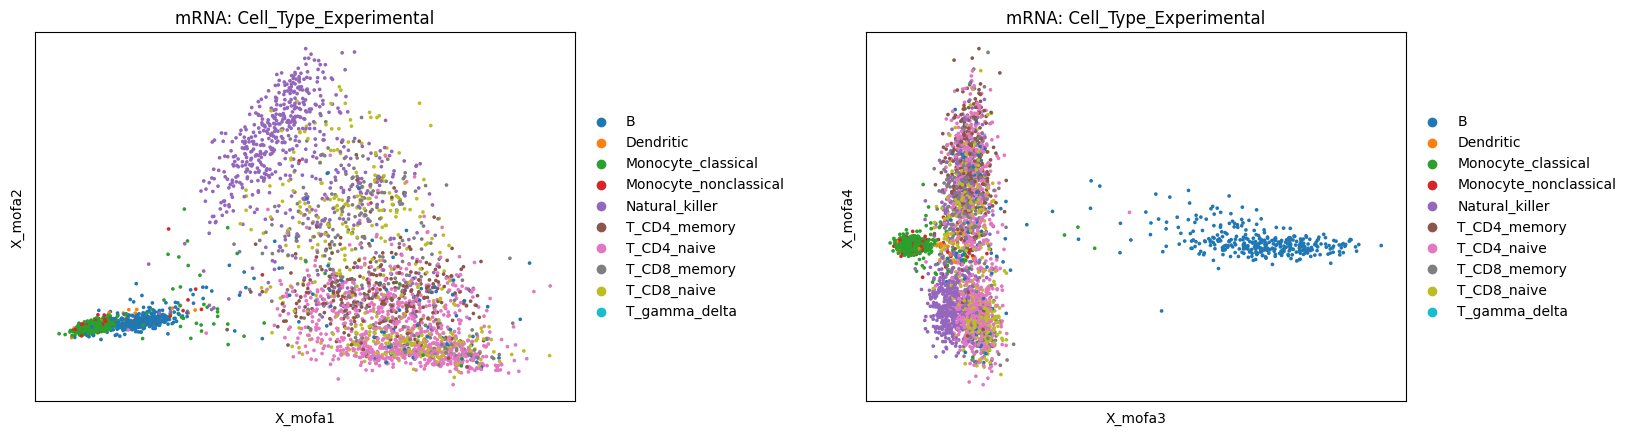

In [17]:
# use Cell_Type_Experimental obs here for rna
mu.pl.mofa(mdata, color="rna:Cell_Type_Experimental", components=["1,2", "3,4"], 
           title= ["mRNA: Cell_Type_Experimental", "mRNA: Cell_Type_Experimental"],
           wspace= 0.4)

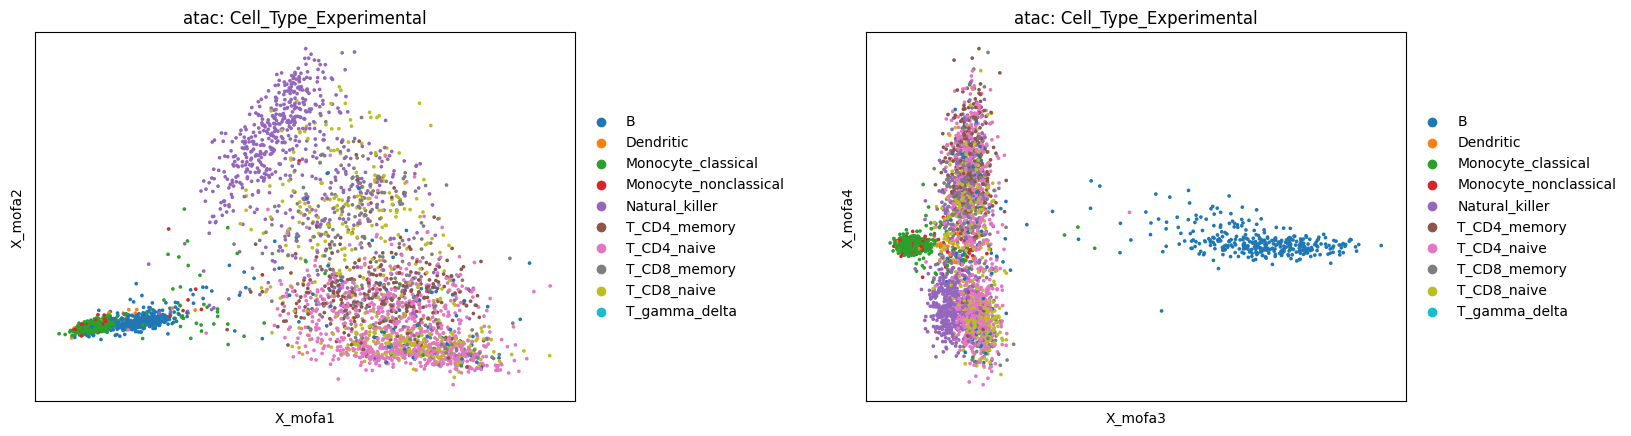

In [18]:
# use Cell_Type_Experimental obs here for atac as well
mu.pl.mofa(mdata, color="atac:Cell_Type_Experimental", components=["1,2", "3,4"],
            title= ["atac: Cell_Type_Experimental", "atac: Cell_Type_Experimental"], wspace= 0.4)

We can then use this embedding not only to compare cell type annotation performed individually on each modality but also to annotate cell types based on both omics jointly.

To visualise all the factors together, we’ll use a non-linear dimensionality reduction method such as UMAP to display the embedding in 2D:

In [19]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)

In [20]:
sc.tl.umap(mdata, min_dist=.2, spread=1., random_state=10)

For instance, we can then visualise how cell type annotations performed on individual modalities correspond to this 2D projection of the joint MOFA embeddings:

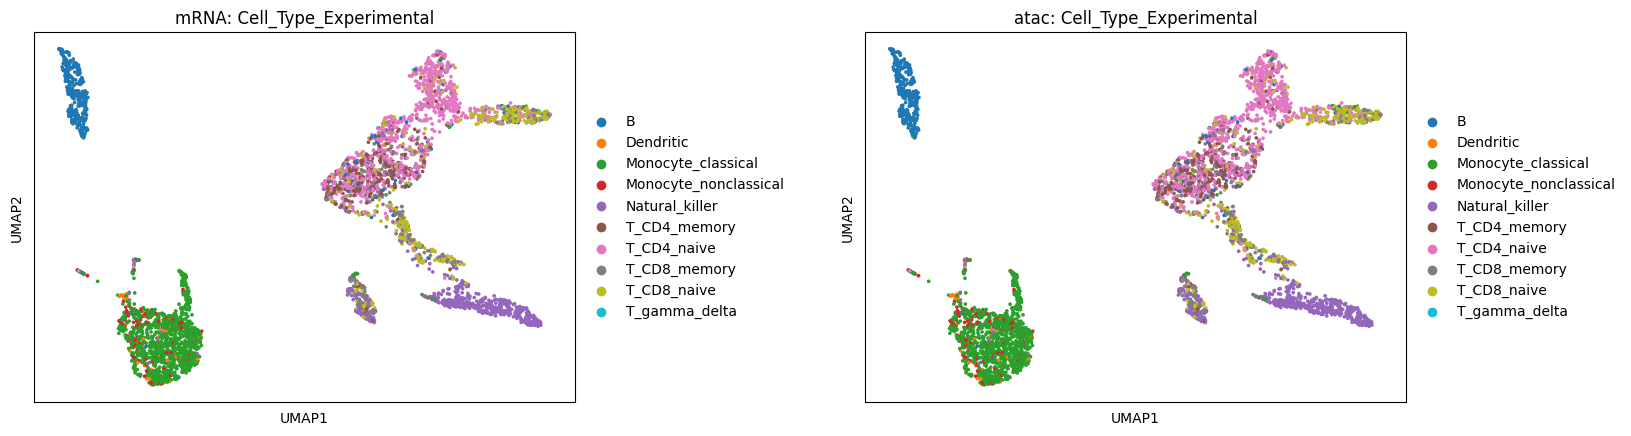

In [21]:
sc.pl.umap(mdata, color=["rna:Cell_Type_Experimental", "atac:Cell_Type_Experimental"], 
           title= ["mRNA: Cell_Type_Experimental", "atac: Cell_Type_Experimental"], wspace=0.4)

Conventional clustering can now be performed based on the MOFA embeddings and also can be visualised on the same UMAP:

In [22]:
sc.tl.leiden(mdata, key_added='leiden_joint')

In [23]:
sc.pl.umap(mdata, color="leiden_joint", legend_loc='on data')

Individual features from modalities are also available when plotting embeddings:

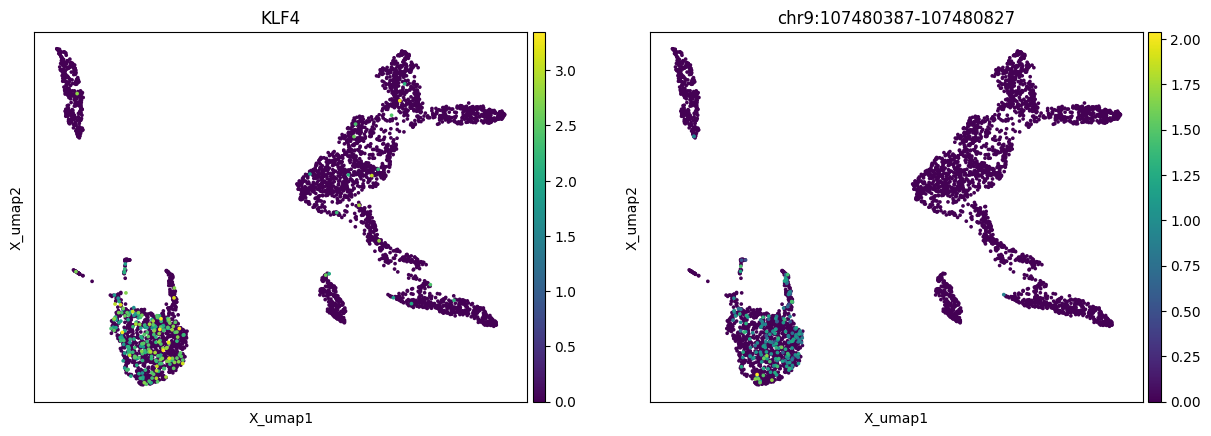

In [24]:
mu.pl.umap(mdata, color=["KLF4", "chr9:107480387-107480827"])

We can also generate custom plots with `matplotlib` and `seaborn`:

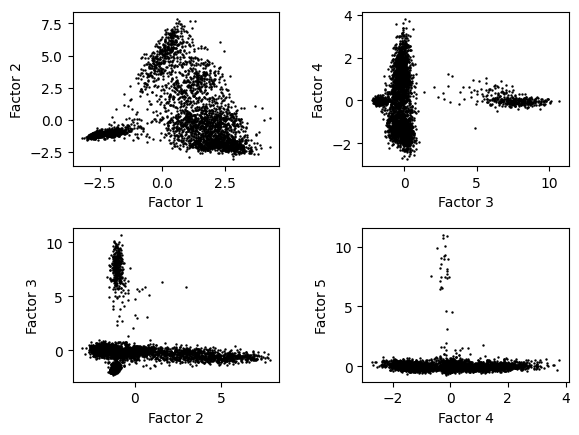

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(mdata.obsm["X_mofa"])
df.columns = [f"Factor {i+1}" for i in range(df.shape[1])]

plot_scatter = lambda i, ax: sns.scatterplot(data=df, x=f"Factor {i+1}", y=f"Factor {i+2}", color="black", linewidth=0, s=3, ax=ax)

fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(4):
    plot_scatter(i, axes[i%2][i//2])

## Annotate cell types
We will now define cell types based on both omics.

In [26]:
mdata['rna'].obs['leiden_joint'] = mdata.obs.leiden_joint
mdata['atac'].obs['leiden_joint'] = mdata.obs.leiden_joint

### Ranking genes and peaks

In [27]:
sc.tl.rank_genes_groups(mdata['rna'], 'leiden_joint', method='t-test_overestim_var')
ac.tl.rank_peaks_groups(mdata['atac'], 'leiden_joint', method='t-test_overestim_var')

### Listing differentially expressed genes and differentially accessible peaks

In [28]:
result = {}
result['rna'] = mdata['rna'].uns['rank_genes_groups']
result['rna']['genes'] = result['rna']['names']
result['atac'] = mdata['atac'].uns['rank_genes_groups']

groups = result['rna']['names'].dtype.names
pd.DataFrame(
    {mod + ':' + group + '_' + key[:1]: result[mod][key][group][:20]
    for group in groups for key in ['names', 'genes', 'pvals']
    for mod in mdata.mod.keys()})

rna:0_n                   atac:0_n    rna:0_g  \
0    ARHGAP15    chr14:64755814-64756291   ARHGAP15   
1        RORA   chr7:151408678-151409411       RORA   
2      CDC14A    chr22:38984997-38985445     CDC14A   
3        IL7R     chr1:57307272-57307904       IL7R   
4      INPP4B    chr15:69468182-69469068     INPP4B   
5        PAG1   chr6:161076208-161076823       PAG1   
6        ANK3     chr2:42132810-42133636       ANK3   
7        BCL2   chr7:130938361-130939021       BCL2   
8   LINC-PINT    chr20:33370248-33370730  LINC-PINT   
9       SYNE2     chr4:52712104-52713105      SYNE2   
10     THEMIS    chr15:56043188-56044036     THEMIS   
11      CAMK4     chr9:33415366-33415964      CAMK4   
12        LTB         chr5:912251-913040        LTB   
13     TTC39C       chr2:9781988-9782720     TTC39C   
14      KAT2B   chr2:147449297-147450100      KAT2B   
15       CD96  chr12:107027407-107028030       CD96   
16    SERINC5  chr11:126062624-126063489    SERINC5   
17      SKAP1       chr1:6460198-6460947      SKAP1   
18       PATJ     chr3:50316635-50317132       PATJ   
19    SLFN12L    chr16:67236208-67236942    SLFN12L   

                                             atac:0_g       rna:0_p  \
0                                       PLEKHG3, SPTB  1.604874e-54   
1                   WDR86-AS1, WDR86, ENSG00000241456  2.137751e-48   
2                              APOBEC3B, APOBEC3B-AS1  2.668037e-36   
3                                                DAB1  7.950328e-33   
4                             DRAIC, RPLP1, LINC02896  9.494467e-33   
5                                              MAP3K4  3.797270e-29   
6                                                      6.229011e-25   
7   LINC00513, ENSG00000271204, ENSG00000273319, L...  1.249671e-24   
8                                            CDK5RAP1  4.666640e-24   
9            DANCR, LINC01618, DANCR, ENSG00000286161  4.921678e-21   
10                                                     4.157189e-19   
11                              AQP7, ENSG00000286322  5.151450e-19   
12                      ENSG00000287600, BRD9, TRIP13  7.665691e-18   
13                                    ENSG00000243491  3.910790e-17   
14                                                     4.592594e-17   
15                                                     3.830875e-17   
16                                               CDON  4.949583e-17   
17           ESPN, ENSG00000231868, TNFRSF25, PLEKHG5  1.964732e-15   
18      HYAL3, NAA80, HYAL1, HYAL2, TUSC2, RASSF1-AS1  3.281692e-15   
19                             FHOD1, SLC9A5, TMEM208  7.223280e-15   

        atac:0_p          rna:1_n                   atac:1_n          rna:1_g  \
0   4.836564e-24           MT-CO1    chr20:40688905-40690326           MT-CO1   
1   6.268887e-20           MT-ND1    chr19:47388758-47389715           MT-ND1   
2   4.336896e-18           MT-CO2   chr7:101717198-101718429           MT-CO2   
3   1.475972e-16           MT-CO3     chr6:44058455-44059525           MT-CO3   
4   1.503717e-16          MT-ATP6  chr12:109827917-109828625          MT-ATP6   
5   7.596879e-16           MT-ND3    chr14:50038398-50039258           MT-ND3   
6   5.107000e-16           MT-ND4      chr19:2168829-2169415           MT-ND4   
7   4.380554e-15           MT-ND2    chr20:50274807-50275522           MT-ND2   
8   8.986613e-15           MT-CYB     chr2:26008682-26009667           MT-CYB   
9   1.188529e-14  ENSG00000289901  chr10:123997406-123998254  ENSG00000289901   
10  1.820512e-14             FCN1   chr6:146543196-146544315             FCN1   
11  7.057127e-14            CSF3R     chr9:87792705-87793716            CSF3R   
12  1.962947e-13          SLC11A1   chr9:107489399-107490409          SLC11A1   
13  4.370189e-13            MYO1F      chr16:8632554-8633320            MYO1F   
14  5.479787e-13          MT-ATP8    chr10:20003613-20004603          MT-ATP8   
15  4.365865e-13             TYMP    chr19:54207948-54208598  

### Assigning cell type labels
Having studied markers of individual clusters, we can add a new inferred cell type annotation to the object.

In [29]:
new_cluster_names = {
    '10': 'B', '14':'B',
    '3':'non-classical mono', 
    '1':'classical mono', '2':'classical mono', '15':'classical mono', '17':'classical mono', 
    '18': 'denderic',
    '6': 'NK', '9': 'NK', '13': 'NK', 
    '0': 'CD4+ memory T', '11': 'CD4+ memory T',  
    '5': 'CD4+ naïve T', '8': 'CD4+ naïve T', '12': 'CD4+ naïve T', 
    '4': 'CD8+ naïve T', '7': 'CD8+ naïve T', '16': 'CD8+ naïve T'
}
mdata.obs['celltype'] = mdata.obs.leiden_joint.astype("str")
mdata.obs.celltype = mdata.obs.celltype.map(new_cluster_names).astype("category")

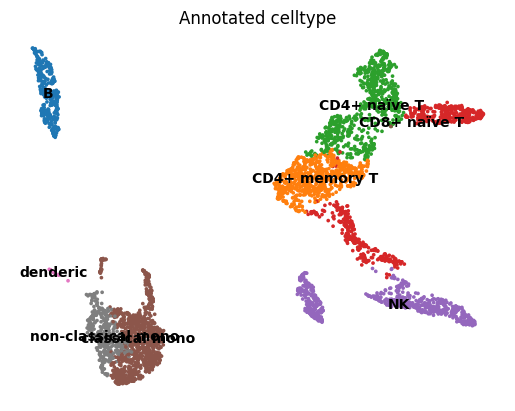

In [30]:
# plotting
mu.pl.umap(mdata, color="celltype", legend_loc="on data", frameon=False, title = "Annotated celltype")

### Visualising markers

In [31]:
mdata['rna'].obs['celltype_joint'] = mdata.obs.celltype
mdata['atac'].obs['celltype_joint'] = mdata.obs.celltype

Finally, we’ll visualise some marker genes across cell types.

In [32]:
marker_genes = [
    'IL7R', 'TRAC', 'GATA3',                                # CD4+ T
    'LEF1', 'FHIT', 'RORA', 'ITGB1',                        # naïve/memory
    'CD8A', 'CD8B', 'CCL5',                                 # CD8+ T
    'GZMH', 'GZMK',                                         # cytotoxic/transitional effector T cells
    'KLRB1', 'SLC4A10',                                     # MAIT
    'IL32',                                                 # T/NK
    'GNLY', 'NKG7',                                         # NK
    'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'IL4R', 'TNFRSF13C',  # B
    'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',               # mono
    'DPYD', 'ITGAM',                                        # classical/intermediate/non-classical mono
    'FCGR3A', 'MS4A7', 'CST3',                              # non-classical mono
    'IRF8', 'TCF4'                                          # DC
]

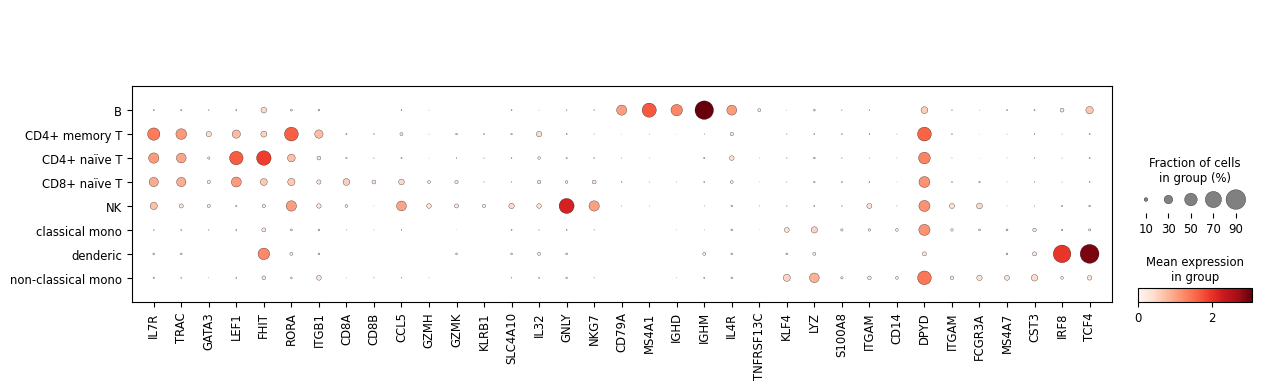

In [33]:
sc.pl.dotplot(mdata['rna'], marker_genes, 'celltype_joint')

## Saving progress on disk
In this notebook we have filtered cells and added MOFA factors & things based on them (neighbourhood graph, clusters, UMAP) to the mdata object, and we’ll finally save our progress on disk:

In [34]:
# Save the filtered data with the newly created annotations in a separate file
# This will make it easy to return to this point by loading this new h5mu file
mdata_filtered_annotated = mu.MuData({'rna': rna, 'atac': atac})
results_file = 'AT206-Std-MO-ATAC_analyzed.h5mu'  # the file that will store the analysis results
mdata_filtered_annotated.write(results_file, compression='gzip')